# Convolutional Nets on the MSNIT Digit Dataset

In this notebook I will build a convolutional neural network to classify handwritten digits from the Kaggle MSNIT dataset. My goal is to create a model that does not overfit the data and has 99%+ accuracy on the test set.

## Data Pre-Processing

In [55]:
# load data

import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [56]:
# seperate labels from pixel data

labels = train.loc[:, 'label']
labels.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [57]:
# one-hot encoding target

from keras.utils import to_categorical

labels = np.array(labels)
labels = to_categorical(labels)
labels[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [58]:
train = train.drop('label', axis=1)
train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
train = np.array(train)
train.shape

(42000, 784)

In [60]:
# original data is 784 pixels, need to reshape to 4D tensor to pass to a convnet

train = train.reshape(42000, 28, 28, 1)
train = train.astype('float32') / 255
train.shape

(42000, 28, 28, 1)

In [61]:
test = np.array(test)
test.shape

(28000, 784)

In [62]:
test = test.reshape(28000, 28, 28, 1)
test = test.astype('float32') / 255
test.shape

(28000, 28, 28, 1)

The data is now properly formatted as 4D tensors and ready for modelling.

## Modelling

The goal for an initial model is two fold: a) be statistically significant - i.e. better then a random baseline - on an applicable metric and b) overfit the training data. You want to overfit the training data initially to ensure that you are not leaving information from the data unused. Subsequent iterations on the original model can tune it to reduce overfitting and make it more generalizable.

I'll begin with a two layer convnet, flattened out to a 512 unit dense layer and then to the final 10 unit (one for each digit 0-9) dense layer with the softmax activation function commonly used for a multi-label classification problem.

In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


The loss function of choice is categorical crossentropy for multi-class classificiaton and the primary metric of concern is accuracy - what percentage of time the model correctly predicts a digit from its image.

In [10]:
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [11]:
history = model.fit(train, labels, batch_size=64, epochs=20, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 33s 976us/step - loss: 0.1795 - accuracy: 0.9440 - val_loss: 0.0595 - val_accuracy: 0.9827
Epoch 2/20
33600/33600 [==============================] - 32s 952us/step - loss: 0.0502 - accuracy: 0.9839 - val_loss: 0.0436 - val_accuracy: 0.9857
Epoch 3/20
33600/33600 [==============================] - 32s 940us/step - loss: 0.0324 - accuracy: 0.9903 - val_loss: 0.0474 - val_accuracy: 0.9875
Epoch 4/20
33600/33600 [==============================] - 31s 937us/step - loss: 0.0236 - accuracy: 0.9924 - val_loss: 0.0425 - val_accuracy: 0.9893
Epoch 5/20
33600/33600 [==============================] - 32s 942us/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 0.0467 - val_accuracy: 0.9890
Epoch 6/20
33600/33600 [==============================] - 32s 947us/step - loss: 0.0126 - accuracy: 0.9962 - val_loss: 0.0457 - val_accuracy: 0.9898
Epoch 7/2

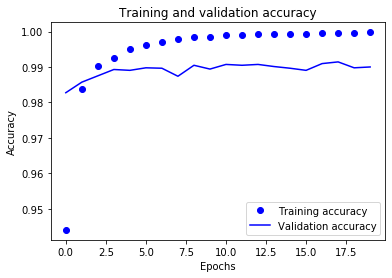

In [14]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(0, 20)

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

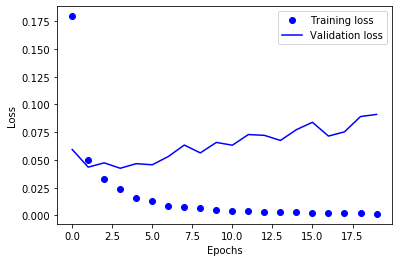

In [13]:
plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This simple convnet with no regularization is extremely accurate on both the test (99%+) and validation (98%+) sets. However, it is clearly badly overfit. As the figure above indicates, the validation loss goes up after 5 epochs, meaning the model is doing progressively worse on unseen data as it better learns the training set.

To combat this overfitting I will first attempt to use data augmentation. By introducting noise into the images the model sees, data augmentation guarantees that the model will never encounter the same image twice and thus hopefully make it more generalizable.

In [17]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_datagen.fit(train)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x=train[:32000], y=labels[:32000])
validation_generator = test_datagen.flow(x=train[32000:], y=labels[32000:])

In [19]:
from math import ceil

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

history = model.fit_generator(train_generator, steps_per_epoch=ceil(32000/64), epochs=20, 
                              validation_data=validation_generator, validation_steps=ceil(10000/64))

Epoch 1/20
500/500 [==============================] - 21s 42ms/step - loss: 1.4031 - accuracy: 0.5165 - val_loss: 0.2789 - val_accuracy: 0.8633
Epoch 2/20
500/500 [==============================] - 21s 41ms/step - loss: 0.8045 - accuracy: 0.7331 - val_loss: 0.2703 - val_accuracy: 0.9024
Epoch 3/20
500/500 [==============================] - 21s 42ms/step - loss: 0.6095 - accuracy: 0.7976 - val_loss: 0.1679 - val_accuracy: 0.9152
Epoch 4/20
500/500 [==============================] - 20s 40ms/step - loss: 0.4913 - accuracy: 0.8421 - val_loss: 0.2090 - val_accuracy: 0.9281
Epoch 5/20
500/500 [==============================] - 23s 46ms/step - loss: 0.4398 - accuracy: 0.8605 - val_loss: 0.3403 - val_accuracy: 0.9393
Epoch 6/20
500/500 [==============================] - 22s 43ms/step - loss: 0.3823 - accuracy: 0.8786 - val_loss: 0.0857 - val_accuracy: 0.9625
Epoch 7/20
500/500 [==============================] - 20s 41ms/step - loss: 0.3538 - accuracy: 0.8870 - val_loss: 0.0944 - val_accuracy:

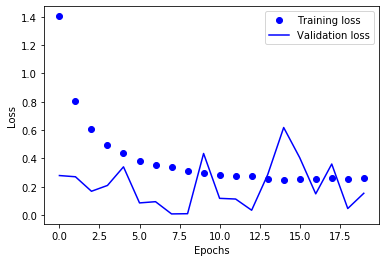

In [20]:
plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

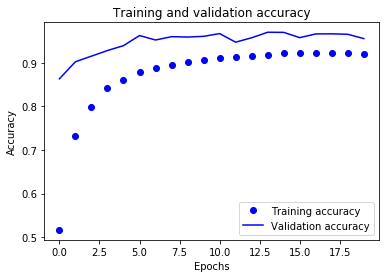

In [21]:
plt.clf()

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This model is signifcantly less overfit, but has drastically diminished accuracy. Data augmentation is introducing too much noise. In the next iteration, I eschew data augmentation in favor of a dropout layer which combats overfitting by randomly dropping features.

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

history = model.fit(train, labels, batch_size=64, epochs=20, validation_split=0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 37s 1ms/step - loss: 0.2205 - accuracy: 0.9309 - val_loss: 0.0742 - val_accuracy: 0.9769
Epoch 2/20
33600/33600 [==============================] - 35s 1ms/step - loss: 0.0789 - accuracy: 0.9752 - val_loss: 0.0477 - val_accuracy: 0.9862
Epoch 3/20
33600/33600 [==============================] - 34s 1ms/step - loss: 0.0612 - accuracy: 0.9811 - val_loss: 0.0425 - val_accuracy: 0.9851
Epoch 4/20
33600/33600 [==============================] - 34s 1ms/step - loss: 0.0484 - accuracy: 0.9855 - val_loss: 0.0344 - val_accuracy: 0.9898
Epoch 5/20
33600/33600 [==============================] - 33s 993us/step - loss: 0.0441 - accuracy: 0.9857 - val_loss: 0.0422 - val_accuracy: 0.9886
Epoch 6/20
33600/33600 [==============================] - 37s 1ms/step - loss: 0.0383 - accuracy: 0.9877 - val_loss: 0.0346 - val_accuracy: 0.9893
Epoch 7/20
33600/33600 [==============================] - 38s 1ms/s

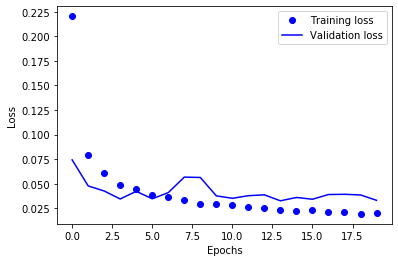

In [23]:
plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

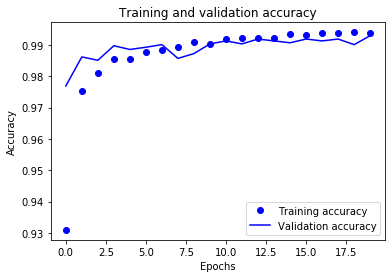

In [24]:
plt.clf()

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Adding a dropout layer produces a very well fit model that is nearly as accurate as the overfit original. Next, I'll compare this to adding weight decay in the form of L2 regulariztion to the two convolutional layers.

In [33]:
from keras import regularizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001),
                        activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

history = model.fit(train, labels, batch_size=64, epochs=20, validation_split=0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 36s 1ms/step - loss: 0.2176 - accuracy: 0.9438 - val_loss: 0.1132 - val_accuracy: 0.9726
Epoch 2/20
33600/33600 [==============================] - 33s 990us/step - loss: 0.0805 - accuracy: 0.9821 - val_loss: 0.0799 - val_accuracy: 0.9830
Epoch 3/20
33600/33600 [==============================] - 34s 1ms/step - loss: 0.0578 - accuracy: 0.9867 - val_loss: 0.0667 - val_accuracy: 0.9840
Epoch 4/20
33600/33600 [==============================] - 33s 986us/step - loss: 0.0458 - accuracy: 0.9899 - val_loss: 0.0614 - val_accuracy: 0.9858
Epoch 5/20
33600/33600 [==============================] - 36s 1ms/step - loss: 0.0372 - accuracy: 0.9924 - val_loss: 0.0546 - val_accuracy: 0.9865
Epoch 6/20
33600/33600 [==============================] - 34s 1ms/step - loss: 0.0321 - accuracy: 0.9936 - val_loss: 0.0774 - val_accuracy: 0.9808
Epoch 7/20
33600/33600 [==============================] - 33s 984

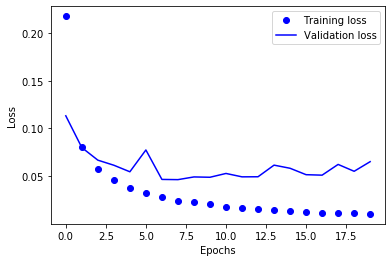

In [34]:
plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

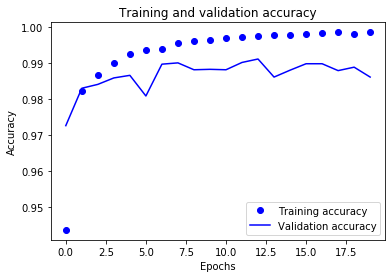

In [36]:
plt.clf()

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

While the accuracy on the training set is improved by weight decay, the accuracy on the validation set is worse. In additon, the model is overfitting after 6 epochs. 

As a final pass, I'll combine dropout and weight decay to see if it results in a more accurate, generalizable model compared to dropout alone.

In [63]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001),
                        activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

history = model.fit(train, labels, batch_size=64, epochs=20, validation_split=0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 36s 1ms/step - loss: 0.2538 - accuracy: 0.9314 - val_loss: 0.0998 - val_accuracy: 0.9786
Epoch 2/20
33600/33600 [==============================] - 35s 1ms/step - loss: 0.1119 - accuracy: 0.9743 - val_loss: 0.0713 - val_accuracy: 0.9852
Epoch 3/20
33600/33600 [==============================] - 35s 1ms/step - loss: 0.0865 - accuracy: 0.9795 - val_loss: 0.0631 - val_accuracy: 0.9869
Epoch 4/20
33600/33600 [==============================] - 34s 1ms/step - loss: 0.0723 - accuracy: 0.9828 - val_loss: 0.0681 - val_accuracy: 0.9837
Epoch 5/20
33600/33600 [==============================] - 34s 1ms/step - loss: 0.0656 - accuracy: 0.9843 - val_loss: 0.0569 - val_accuracy: 0.9873
Epoch 6/20
33600/33600 [==============================] - 34s 1ms/step - loss: 0.0605 - accuracy: 0.9849 - val_loss: 0.0520 - val_accuracy: 0.9882
Epoch 7/20
33600/33600 [==============================] - 34s 1ms/ste

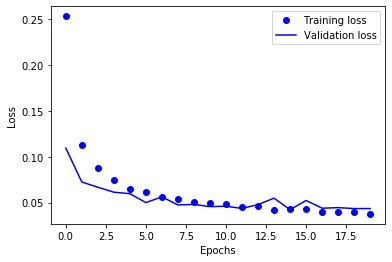

In [39]:
plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

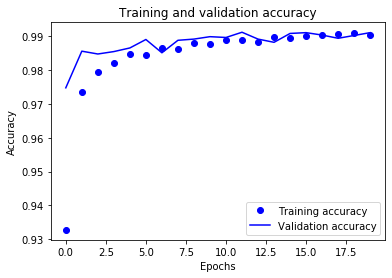

In [40]:
plt.clf()

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [68]:
np.argmax(history.history["val_accuracy"])

15

This model is extremely well fit and actually performs better on the validation data compared to the test data after 15 epochs! The validation accuracy peaks after 15 epochs, so I'll retrain the model, restricting it to 15 epochs, and submit it to Kaggle for an official score.

In [70]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001),
                        activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

history = model.fit(train, labels, batch_size=64, epochs=15, validation_split=0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/15
33600/33600 [==============================] - 34s 1ms/step - loss: 0.2626 - accuracy: 0.9281 - val_loss: 0.1071 - val_accuracy: 0.9768
Epoch 2/15
33600/33600 [==============================] - 34s 1ms/step - loss: 0.1174 - accuracy: 0.9728 - val_loss: 0.0701 - val_accuracy: 0.9862
Epoch 3/15
33600/33600 [==============================] - 34s 1ms/step - loss: 0.0878 - accuracy: 0.9797 - val_loss: 0.0621 - val_accuracy: 0.9869
Epoch 4/15
33600/33600 [==============================] - 34s 1ms/step - loss: 0.0759 - accuracy: 0.9818 - val_loss: 0.0528 - val_accuracy: 0.9890
Epoch 5/15
33600/33600 [==============================] - 34s 1ms/step - loss: 0.0665 - accuracy: 0.9833 - val_loss: 0.0522 - val_accuracy: 0.9879
Epoch 6/15
33600/33600 [==============================] - 34s 1ms/step - loss: 0.0623 - accuracy: 0.9842 - val_loss: 0.0593 - val_accuracy: 0.9855
Epoch 7/15
33600/33600 [==============================] - 34s 1ms/ste

## Submission

In [71]:
predictions = model.predict_classes(test)
predictions

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [72]:
labels = np.array(range(1, predictions.size + 1))
labels

array([    1,     2,     3, ..., 27998, 27999, 28000])

In [73]:
submission = {'ImageId': labels, 'Label': predictions}
submission

{'ImageId': array([    1,     2,     3, ..., 27998, 27999, 28000]),
 'Label': array([2, 0, 9, ..., 3, 9, 2], dtype=int64)}

In [76]:
submission = pd.DataFrame(submission)
submission.to_csv('submission.csv', index=False)

![score](digit_recognizer_score.png)

99.071% accurate on the Kaggle test data and a well fit model.

While the model could be improved on with additional layers and further hyperparameter tuning, I do not have the available computing power to easily effect such an improvement. In any event, my goals are accomplished and I will leave it here.